/tmp/ipykernel_23128/570187978.py:90: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  J = np.trapz(I**2, t_weeks) + 0.05 * np.sum(u_t_values**2)


✅ تم إيجاد التحكم الأمثل بنجاح
u_treat المثلى لكل أسبوع: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


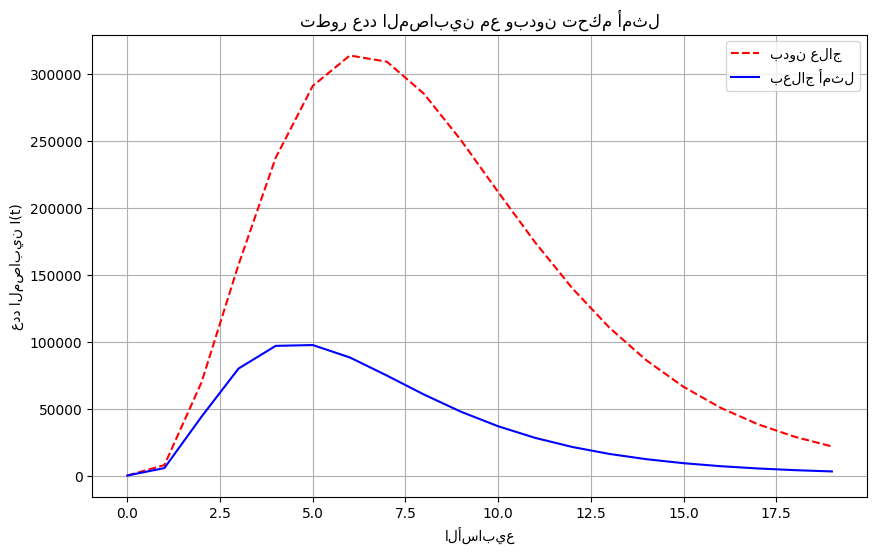

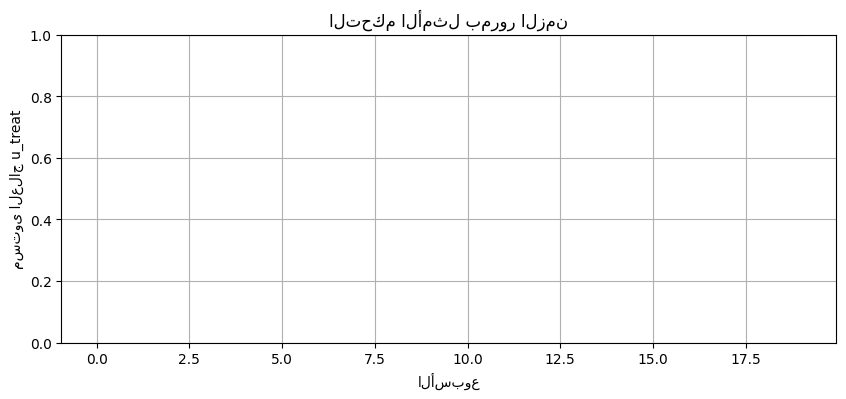

In [1]:
import numpy as np
from dataclasses import dataclass
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ======================
# نموذج SEIRC-C (من الكود السابق)
# ======================
kappa = 5000

@dataclass
class Params:
    N: float
    beta1: float
    beta2: float
    sigma: float
    gamma: float
    mu: float
    delta: float
    eta: float
    epsilon: float
    kappa: float
    u_vac: float = 0.0
    u_san: float = 0.0
    u_treat: float = 0.0

@dataclass
class ControlGains:
    k_s_to_delta: float = 9.0
    k_s_to_beta2: float = 0.98
    k_s_to_eta:   float = 0.6
    k_s_to_eps:   float = 0.8
    k_v_to_beta:  float = 1.0
    k_t_to_gamma: float = 3.0
    k_t_to_mu:    float = 0.9

def _effective_params(p: Params, k: ControlGains):
    u_v = np.clip(p.u_vac, 0, 1)
    u_s = np.clip(p.u_san, 0, 1)
    u_t = np.clip(p.u_treat, 0, 1)

    susc_scale = (1.0 - k.k_v_to_beta * u_v)
    delta_eff = p.delta * (1.0 + k.k_s_to_delta * u_s)
    beta2_eff = p.beta2 * max(0.0, 1.0 - k.k_s_to_beta2 * u_s)
    eta_eff   = p.eta * (1.0 - k.k_s_to_eta * u_s)
    eps_eff   = p.epsilon * (1.0 - k.k_s_to_eps * u_s)
    gamma_eff = p.gamma * (1.0 + k.k_t_to_gamma * u_t)
    mu_eff    = p.mu * (1.0 - k.k_t_to_mu * u_t)

    return dict(
        susc_scale=susc_scale, delta_eff=delta_eff, beta2_eff=beta2_eff,
        eta_eff=eta_eff, eps_eff=eps_eff, gamma_eff=gamma_eff, mu_eff=mu_eff
    )

def rhs(t, y, p: Params, gains: ControlGains, u_treat_func):
    S, E, I, R, C, A, D = y
    p_dyn = Params(**{**p.__dict__, 'u_treat': float(np.clip(u_treat_func(t), 0, 1))})
    eff = _effective_params(p_dyn, gains)

    lambda_dir = p.beta1 * I / p.N
    lambda_env = eff["beta2_eff"] * C / (C + kappa)
    lambda_tot = eff["susc_scale"] * (lambda_dir + lambda_env)

    dS = -lambda_tot * S
    dE = lambda_tot * S - p.sigma * E
    dI = p.sigma * E - eff["gamma_eff"] * I - eff["mu_eff"] * I
    dR = eff["gamma_eff"] * I
    dC = eff["eta_eff"] * I * (1 - C / p.kappa) + eff["eps_eff"] * C - eff["delta_eff"] * C
    dA = p.sigma * E
    dD = eff["mu_eff"] * I
    return np.array([dS, dE, dI, dR, dC, dA, dD])

# ======================
# التحكم الأمثل في u_treat
# ======================

def objective(u_t_values, t_weeks, y0, params, gains):
    """دالة الهدف: نقلل عدد المصابين مع تكلفة علاج بسيطة"""
    def u_t_func(t):
        idx = int(np.clip(np.floor(t), 0, len(u_t_values) - 1))
        return u_t_values[idx]

    sol = solve_ivp(lambda t, y: rhs(t, y, params, gains, u_t_func),
                    (t_weeks[0], t_weeks[-1]), y0, t_eval=t_weeks,
                    rtol=1e-6, atol=1e-8)

    I = sol.y[2]
    # الهدف: نقلل مجموع I^2 + تكلفة صغيرة على العلاج
    J = np.trapz(I**2, t_weeks) + 0.05 * np.sum(u_t_values**2)
    return J

# ======================
# إعداد البيانات
# ======================
params = Params(
    N=1e6, beta1=0.7, beta2=0.5, sigma=1/2, gamma=1/3, mu=0.01,
    delta=0.1, eta=5.0, epsilon=0.05, kappa=5000
)
gains = ControlGains()

weeks = np.arange(0, 20, 1)  # 20 أسبوعًا
I0 = 100
E0 = 50
y0 = [params.N - E0 - I0, E0, I0, 0, 0, 0, 0]

# ======================
# تحسين التحكم
# ======================
u0 = np.zeros(len(weeks))
bounds = [(0, 1)] * len(u0)

res = minimize(objective, u0, args=(weeks, y0, params, gains),
               bounds=bounds, method='L-BFGS-B')

u_opt = res.x
print("✅ تم إيجاد التحكم الأمثل بنجاح")
print("u_treat المثلى لكل أسبوع:", np.round(u_opt, 3))

# ======================
# مقارنة النتائج
# ======================
def simulate_with_control(u_values):
    def u_func(t):
        idx = int(np.clip(np.floor(t), 0, len(u_values) - 1))
        return u_values[idx]

    sol = solve_ivp(lambda t, y: rhs(t, y, params, gains, u_func),
                    (weeks[0], weeks[-1]), y0, t_eval=weeks)
    return sol

sol_no = simulate_with_control(np.zeros_like(u_opt))
sol_opt = simulate_with_control(u_opt)

# ======================
# رسم النتائج
# ======================
plt.figure(figsize=(10,6))
plt.plot(weeks, sol_no.y[2], 'r--', label='بدون علاج')
plt.plot(weeks, sol_opt.y[2], 'b-', label='بعلاج أمثل')
plt.xlabel('الأسابيع')
plt.ylabel('عدد المصابين I(t)')
plt.title('تطور عدد المصابين مع وبدون تحكم أمثل')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.step(weeks, u_opt, where='post')
plt.ylim(0,1)
plt.xlabel('الأسبوع')
plt.ylabel('مستوى العلاج u_treat')
plt.title('التحكم الأمثل بمرور الزمن')
plt.grid(True)
plt.show()
